In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.vision.gan import *
from urllib.parse import urlparse
import torch.nn as nn
import torch.nn.functional as F

# DATA

In [10]:
realImagesPath = untar_data("http://vis-www.cs.umass.edu/lfw/lfw-a")
realImagesPath

PosixPath('/root/.fastai/data/lfw-a')

In [0]:
# For whatever reason the "-a" isn't included in the folder name by tarfile.extractall
realImagesPath = realImagesPath.parent/'lfw'

In [0]:
sampleImg1Path = realImagesPath/'Aaron_Eckhart/Aaron_Eckhart_0001.jpg'

In [39]:
from PIL import Image

im = Image.open(sampleImg1Path)
im.size

(250, 250)

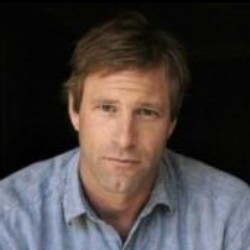

In [45]:
from IPython.display import Image
Image(filename=str(sampleImg1Path))


GANItemList stores NoisyItem's in x and the input images in y (target)

In [0]:
def get_data(path, bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

# CRITIC

In [47]:
# PLATFORM DEPENDENT CODE !!!!!
base_dir = '/content'

if (importlib.util.find_spec("google.colab") is not None):
  from google.colab import drive
  
  drive.mount('/content/gdrive', force_remount=True)
  root_dir = "/content/gdrive/My Drive/"
  base_dir = root_dir + 'ML/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Load a pretrained discriminator. Pending research about whether it's good to start with a pretrained one, kind of more knolewdgeable than the generator.

In [48]:
critic = load_learner(base_dir, 'faceBinaryClassifierResnet18_1.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'fastai.layers.AdaptiveConcatPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'fastai.layers.Flatten' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [0]:
def loadNewTestImage(url: str, filename: str, testRootDir:Path):
  parsedUrl = urlparse(url)
  ext = os.path.splitext(parsedUrl.path)[1]
  path = testRootDir/(filename + ext)
  download_url(url, path)
  img = open_image(path)
  return img

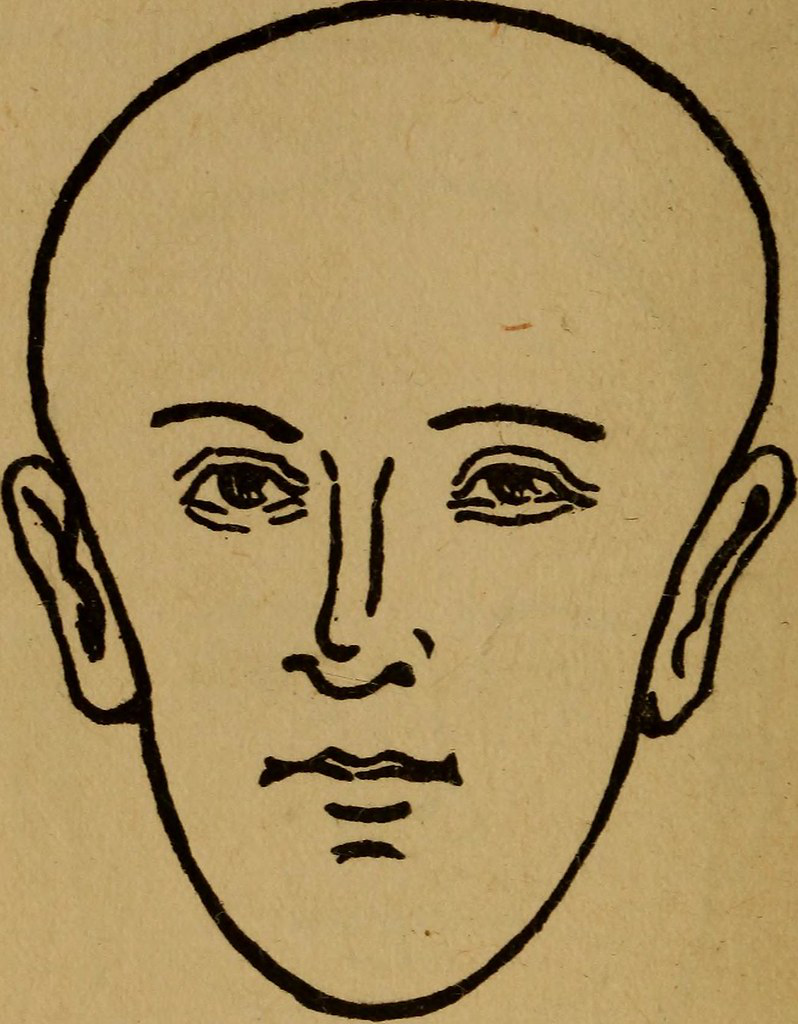

In [50]:
img = loadNewTestImage('https://live.staticflickr.com/3844/14761664536_f875cf6b9c_b.jpg', 'fakeFace', Path('/content'))
img

In [51]:
critic.predict(img)

(Category negative, tensor(0), tensor([0.9978, 0.0022]))

# GENERATOR

In [52]:
#Testing a transpose convolution
input = torch.rand(64, 100, 1, 1)
nn.ConvTranspose2d(100, 1024, 4, padding=0, stride=1)(input).size()

torch.Size([64, 1024, 4, 4])

In [0]:
class ConvTransBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ConvTransBlock, self).__init__()
    self.conv = nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, (4, 4), padding=1, stride=2),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
    )
    
  def forward(self, x):
    return self.conv(x)

class GeneratorNet(nn.Module):
  def __init__(self):
    super(GeneratorNet, self).__init__()
    self.layers = nn.Sequential(
      #nn.Linear(100, 1024 * 4 * 4),
      nn.ConvTranspose2d(100, 1024, 4, padding=0, stride=1),
      ConvTransBlock(1024, 512),
      ConvTransBlock(512, 256),
      ConvTransBlock(256, 128),
      #ConvTransBlock(128, 64)
      nn.ConvTranspose2d(128, 3, 4, padding=1, stride=2),
      nn.Tanh()
    )

  def forward(self, x):
    # x = x.view(1024, 4, 4) Use it when putting FC at the beginning
    x = self.layers(x)
    return x

In [54]:
#Testing a forward pass through the generator
input = torch.rand(64, 100, 1, 1)
input = GeneratorNet().forward(input)
input.size()

torch.Size([64, 3, 64, 64])

# GAN LEARNER

In [0]:
# GANLearner(
#     data:DataBunch, 
#     generator:Module, 
#     critic:Module, 
#     gen_loss_func:LossFunction, 
#     crit_loss_func:LossFunction, 
#     switcher:Callback=None, 
#     gen_first:bool=False, 
#     switch_eval:bool=True, 
#     show_img:bool=True, 
#     clip:float=None, 
#     **learn_kwargs) :: Learner

In [0]:
def gan_loss_from_func(loss_gen, loss_crit, weights_gen:Tuple[float,float]=None):
    "Define loss functions for a GAN from `loss_gen` and `loss_crit`."
    def _loss_G(fake_pred, output, target, weights_gen=weights_gen):
        ones = fake_pred.new_ones(fake_pred.shape[0])
        weights_gen = ifnone(weights_gen, (1.,1.))
        return weights_gen[0] * loss_crit(fake_pred, ones) + weights_gen[1] * loss_gen(output, target)

    def _loss_C(real_pred, fake_pred):
        ones  = real_pred.new_ones (real_pred.shape[0])
        zeros = fake_pred.new_zeros(fake_pred.shape[0])
        return (loss_crit(real_pred, ones) + loss_crit(fake_pred, zeros)) / 2

    return _loss_G, _loss_C

In [0]:
data = get_data(realImagesPath, 64, 64)
generator = GeneratorNet()
#losses = gan_loss_from_func(learn_gen.loss_func, learn_crit.loss_func, weights_gen=weights_gen)
# weights_gen might be useful when using an additional loss function for the generator
# weights_gen[0]=weight for "standard" loss function (comparing ones with D(G(z)))
# weights_gen[1]= weights for results of extra loss function)

# No extra func for gen, only log(D(G(z)))
losses = gan_loss_from_func(lambda *args: 0, nn.BCELoss) 

learner = GANLearner(
  data,
  generator,
  critic.model,
  *losses)

In [60]:
data

ImageDataBunch;

Train: LabelList (1054 items)
x: GANItemList
,,,,
y: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
Path: /root/.fastai/data/lfw;

Valid: LabelList (0 items)
x: GANItemList

y: ImageList

Path: /root/.fastai/data/lfw;

Test: None

In [0]:
!cat /usr/local/lib/python3.6/dist-packages/fastai/vision/gan.py

In [0]:
!cat /usr/local/lib/python3.6/dist-packages/fastai/datasets.py

PENDING:

* Revisit transforms (get_data)
* Find extra loss functions for generator and pass it to gan_loss_from_func. Maybe pixel loss???, feature loss???
* What if I make the final convolution a normal convolution with in_channels=out_channels (probably together with uncommenting the last ConvBlock call)? 
* Try replacing first convolution with FC layer + reshape (view)
*  Further research about that first layer "project and reshape"
*  Using a pretrained critic might be a bad idea, especially thinking about the gradients used by the generator to improve